In [1]:
CUDA_INDEX = 0
NAME = 'DBLP'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroSED     ', torch.load(f'../preds/{NAME}/inner_pred.pt', map_location='cpu')),
#     ('NeuroSED-NN  ', torch.load(f'../preds/{NAME}/nn_inner_pred.pt', map_location='cpu')),
#     ('NeuroSED-Dual', torch.load(f'../preds/{NAME}/dual_inner_pred.pt', map_location='cpu')),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_inner.npy'))),
#     ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_inner.npy'))),
#     ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_inner_pred.npy'))),
#     ('Branch        ', torch.load(f'../preds/{NAME}/b_inner_pred.pt', map_location='cpu')),
#     ('F2            ', torch.load(f'../preds/{NAME}/f2_inner_pred.pt', map_location='cpu')),
]

In [6]:
def f(x):
    if(x>50):
        return 0
    elif x<-50:
        return 0
    else:
        return x

In [5]:
inner_test_set, _ = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/inner_test.pt', map_location='cpu')
queries, _, lb, ub = inner_test_set
sed = (lb+ub)/2

In [10]:
## bound predictions
print('=== RMSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
#     pred = torch.Tensor(list(map(f,pred)))
    print(f'{metrics.rmse(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.mae(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.r2(lb, ub, pred)*100:.2f}')
#     print()

=== RMSE / MAE / R2 ===

0.964 / 0.626 / 97.30
1.470 / 0.926 / 93.73
1.552 / 0.966 / 93.01
1.482 / 0.911 / 93.63
2.917 / 2.156 / 75.31
3.427 / 2.165 / 65.92


In [23]:
## remove outliers predictions

def valid(pred):
    return (pred<50) & (pred>-50)
    

print('=== RMSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
    val = valid(pred)
    print(lb[~val])
    print(ub[~val])
    print(pred[~val])
    print()
    pred,lb_,ub_ = pred[val],lb[val],ub[val]
    print(f'{metrics.rmse(lb_, ub_, pred):.3f}', end=' / ')
    print(f'{metrics.mae(lb_, ub_, pred):.3f}', end=' / ')
    print(f'{metrics.r2(lb_, ub_, pred)*100:.2f}')
#     print()

=== RMSE / MAE / R2 ===

tensor([])
tensor([])
tensor([])

0.964 / 0.626 / 97.30
tensor([0.])
tensor([12.])
tensor([-10783.0615])

1.730 / 1.001 / 91.32
tensor([])
tensor([])
tensor([])

1.045 / 0.666 / 96.83


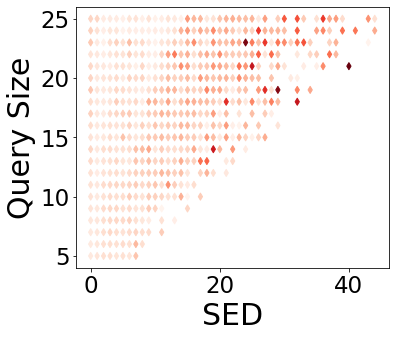

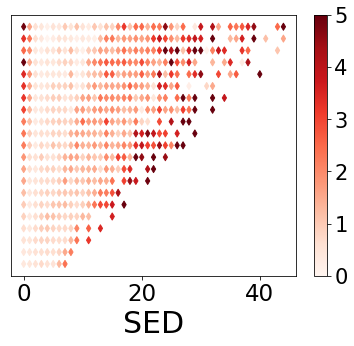

In [9]:
for i, (label, pred) in enumerate(preds):
    if i == 0:
        plt.figure(figsize=(5.6,4.8))
    elif i == len(preds)-1:
        plt.figure(figsize=(6.4,4.8))
    else:
        plt.figure(figsize=(4.8,4.8))
    err = metrics.err(lb, ub, pred)
    gsz = torch.tensor([g.num_nodes for g in queries])
    viz.plot_corr_2d(sed, gsz, err, xmax1=50, xmax2=25, bin_size1=1, bin_size2=1, s=25, cmap='Reds', vmax=5, vmin=0, marker='d')
    if i == len(preds)-1:
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=21)
    plt.xlabel('SED', fontsize=30)
    if i == 0:
        plt.ylabel('Query Size', fontsize=30)
    else:
        plt.yticks([])
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.savefig(f'../plots/Heatmap.{NAME}.{i}_{label.strip()}.eps', bbox_inches='tight')
    plt.show()
    plt.close()

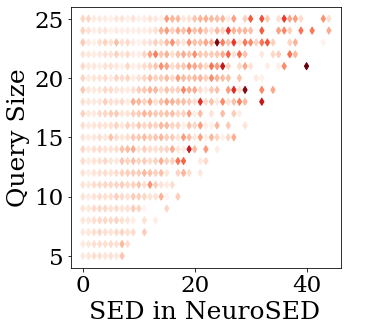

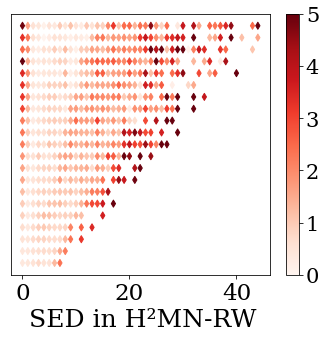

In [32]:
# import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

for i, (label, pred) in enumerate(preds):
    if i == 0:
        plt.figure(figsize=(4.85,4.8))
    elif i == len(preds)-1:
        plt.figure(figsize=(5.8,4.8))
    else:
        plt.figure(figsize=(4.8,4.8))
    err = metrics.err(lb, ub, pred)
    gsz = torch.tensor([g.num_nodes for g in queries])
    viz.plot_corr_2d(sed, gsz, err, xmax1=50, xmax2=25, bin_size1=1, bin_size2=1, s=25, cmap='Reds', vmax=5, vmin=0, marker='d')
    if i == len(preds)-1:
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=21)
        plt.xlabel(f'SED in H\u00b2MN-RW', fontsize=25, position=(0.51,0))
    if i == 0:
        plt.xlabel(f'SED in {label}', fontsize=25, position=(0.57,0))
        plt.ylabel('Query Size', fontsize=25)
    else:
        plt.yticks([])
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.savefig(f'../plots/HeatmapMain.{NAME}.{i}_{label.strip()}.eps', bbox_inches='tight')
    plt.show()
    plt.close()